<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Process-CCSs" data-toc-modified-id="Process-CCSs-1">Process CCSs</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1.1">Setup</a></span></li><li><span><a href="#PacBio-amplicons" data-toc-modified-id="PacBio-amplicons-1.2">PacBio amplicons</a></span></li><li><span><a href="#CCS-stats-for-PacBio-runs" data-toc-modified-id="CCS-stats-for-PacBio-runs-1.3">CCS stats for PacBio runs</a></span></li><li><span><a href="#Align-CCSs-to-amplicons" data-toc-modified-id="Align-CCSs-to-amplicons-1.4">Align CCSs to amplicons</a></span></li><li><span><a href="#Write-valid-CCSs" data-toc-modified-id="Write-valid-CCSs-1.5">Write valid CCSs</a></span></li></ul></li></ul></div>

# Process CCSs
This Python Jupyter notebook processes the PacBio circular consensus sequences (CCSs) to extract barcodes and call mutations in the gene.

Define the background for CCS mapping

In [1]:
background = "E484K"

## Setup

Import Python modules

Plotting is done with [plotnine](https://plotnine.readthedocs.io/en/stable/), which uses ggplot2-like syntax.

The analysis uses the Bloom lab's [alignparse](https://jbloomlab.github.io/alignparse) and [dms_variants](https://jbloomlab.github.io/dms_variants) packages.

In [2]:
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets

import dms_variants
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [3]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [4]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")

Using alignparse version 0.2.4
Using dms_variants version 0.8.9


Ignore warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory for figures:

In [7]:
os.makedirs(config['process_ccs_dir'], exist_ok=True)

## PacBio reads
Get the amplicons sequenced by PacBio as the alignment target along with the specs on how to parse the features:

In [8]:
pacbio_runs = (
    pd.read_csv(config['pacbio_runs'], dtype=str)
    .drop(columns=['ccs'])
    .assign(name=lambda x: x['library'] + '_' + x['bg'] + '_' + x['run'],
            fastq=lambda x: config['ccs_dir'] + '/' + x['name'] + '_ccs.fastq.gz'
            )
    )
 
pacbio_runs.drop(pacbio_runs[pacbio_runs['bg'] != background].index,inplace=True)

display(HTML(pacbio_runs.to_html(index=False)))

library,bg,run,name,fastq
pool1,E484K,210701_A,pool1_E484K_210701_A,results/ccs/pool1_E484K_210701_A_ccs.fastq.gz
pool2,E484K,210701_A,pool2_E484K_210701_A,results/ccs/pool2_E484K_210701_A_ccs.fastq.gz


## PacBio amplicons
Get the amplicons sequenced by PacBio as the alignment target along with the specs on how to parse the features:

In [9]:
print(f"Reading amplicons from {config['amplicons_' + background]}")
print(f"Reading feature parse specs from {config['feature_parse_specs_' + background]}")

targets = alignparse.targets.Targets(
                seqsfile=config['amplicons_' + background],
                feature_parse_specs=config['feature_parse_specs_' + background])

Reading amplicons from data/PacBio_amplicon_E484K.gb
Reading feature parse specs from data/feature_parse_specs_E484K.yaml


Draw the target amplicons:

Saving plot to results/process_ccs/amplicons.pdf


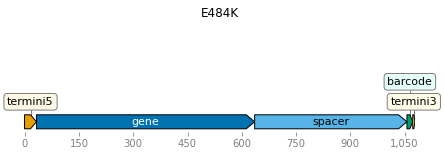

In [10]:
fig = targets.plot(ax_width=7,
                   plots_indexing='biopython',  # numbering starts at 0
                   ax_height=2,  # height of each plot
                   hspace=1.2,  # vertical space between plots
                   )

plotfile = os.path.join(config['process_ccs_dir'], 'amplicons.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

Write out the specs used to parse the features (these are the same specs provided as `feature_parse_specs` when initializing `targets`, but with defaults filled in):

In [11]:
print(targets.feature_parse_specs('yaml'))

E484K:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  gene:
    filter:
      mutation_nt_count: 90
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
    - accuracy
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  barcode:
    filter:
      mutation_nt_count: 0
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - sequence
    - accuracy
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []



## Align CCSs to amplicons
We now align the CCSs to the amplicon and parse features from the resulting alignments using the specs above.

First, we initialize an `alignparse.minimap2.Mapper` to align the reads to SAM files:

In [12]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.18-r1015 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


Next, we use `Targets.align_and_parse` to create the alignments and parse them:

In [13]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

First, examine the read stats from the alignment / parsing, both extracting alignment target name and getting stats aggregated by target:

In [14]:
readstats = (
    readstats
    .assign(category_all_targets=lambda x: x['category'].str.split().str[0],
            target=lambda x: x['category'].str.split(None, 1).str[1],
            valid=lambda x: x['category_all_targets'] == 'aligned')
    )

Now plot the read stats by run (combining all targets and libraries within a run):

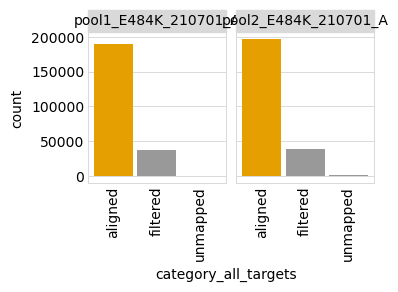

In [15]:
ncol = 2
p = (
    ggplot(readstats
           .groupby(['name', 'category_all_targets', 'valid'])
           .aggregate({'count': 'sum'})
           .reset_index(),
           aes('category_all_targets', 'count', fill='valid')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', ncol=ncol) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.85 * min(ncol, len(pacbio_runs)),
                       2 * math.ceil(len(pacbio_runs) / ncol)),
          panel_grid_major_x=element_blank(),
          legend_position='none',
          ) +
    scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

And the read stats by library (combining all targets and runs within a library):

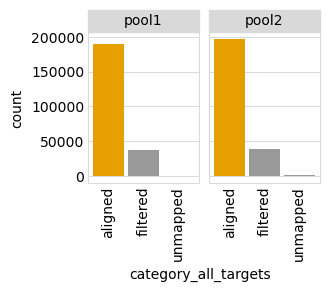

In [16]:
p = (
    ggplot(readstats
           .groupby(['library', 'category_all_targets', 'valid'])
           .aggregate({'count': 'sum'})
           .reset_index(), 
           aes('category_all_targets', 'count', fill='valid')) +
    geom_bar(stat='identity') +
    facet_wrap('~ library', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * pacbio_runs['library'].nunique(), 2),
          panel_grid_major_x=element_blank(),
          legend_position='none',
          ) +
    scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

And the number of reads by target (combining all libraries and runs for a target):

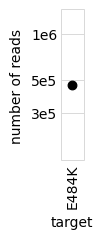

In [17]:
p = (
    ggplot(readstats
           .groupby(['target'])
           .aggregate({'count': 'sum'})
           .reset_index(), 
           aes('target', 'count')) +
    geom_point(stat='identity', size=3) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.3 * readstats['target'].nunique(), 2),
          panel_grid_major_x=element_blank(),
          ) +
    scale_y_log10(name='number of reads')
    )
_ = p.draw()

And read stats by target (combining all libraries and runs for a target):

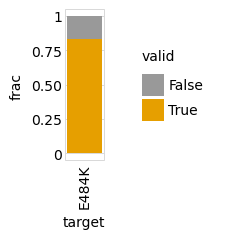

In [18]:
p = (
    ggplot(readstats
           .groupby(['target', 'valid'])
           .aggregate({'count': 'sum'})
           .reset_index()
           .assign(total=lambda x: x.groupby('target')['count'].transform('sum'),
                   frac=lambda x: x['count'] / x['total'],
                   ), 
           aes('target', 'frac', fill='valid')) +
    geom_bar(stat='identity') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.5 * readstats['target'].nunique(), 2),
          panel_grid_major_x=element_blank(),
          ) +
    scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

Now let's see **why** we filtered the reads.
First, we do some transformations on the `filtered` dict returned by `Targets.align_and_parse`.
Then we count up the number of CCSs filtered for each reason, and group together "unusual" reasons that represent less than some fraction of all filtering.
For now, we group together all targets to the stats represent all targets combined:

In [19]:
other_cutoff = 0.02  # group as "other" reasons with <= this frac

filtered_df = (
    pd.concat(df.assign(target=target) for target, df in filtered.items())
    .groupby(['library', 'name', 'run', 'filter_reason'])
    .size()
    .rename('count')
    .reset_index()
    .assign(tot_reason_frac=lambda x: (x.groupby('filter_reason')['count']
                                       .transform('sum')) / x['count'].sum(),
            filter_reason=lambda x: numpy.where(x['tot_reason_frac'] > other_cutoff,
                                                x['filter_reason'],
                                                'other')
            )
    )

Now plot the filtering reason for all runs:

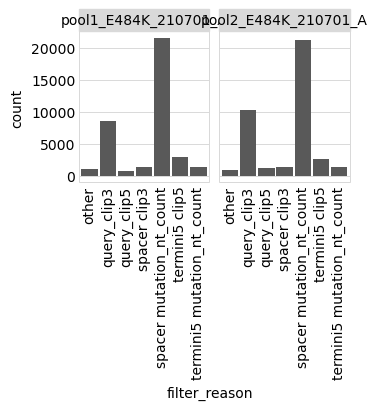

In [20]:
ncol = 7
nreasons = filtered_df['filter_reason'].nunique()

p = (
    ggplot(filtered_df, aes('filter_reason', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', ncol=ncol) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.25 * nreasons * min(ncol, len(pacbio_runs)),
                       2 * math.ceil(len(pacbio_runs) / ncol)),
          panel_grid_major_x=element_blank(),
          )
    )
_ = p.draw()

Now make a similar plot to above, but combine all the runs for each library:

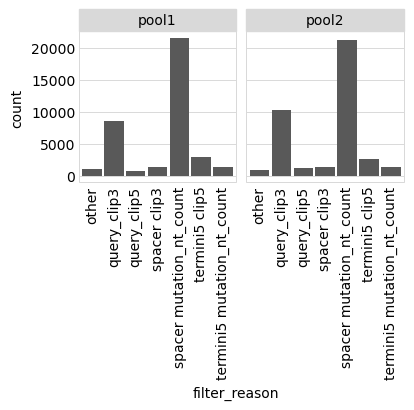

In [21]:
p = (
    ggplot(filtered_df
           .groupby(['library', 'filter_reason'])
           .aggregate({'count': 'sum'})
           .reset_index(),
           aes('filter_reason', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ library', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.3 * nreasons * pacbio_runs['library'].nunique(), 2),
          panel_grid_major_x=element_blank(),
          )
    )
_ = p.draw()

Finally, we take the successfully parsed alignments and read them into a data frame, keeping track of the target that each CCS aligns to.
We also drop the pieces of information we won't use going forward, and rename a few columns:

In [22]:
aligned_df = (
    pd.concat(df.assign(target=target) for target, df in aligned.items())
    .drop(columns=['query_clip5', 'query_clip3', 'run','name'])
    .rename(columns={'barcode_sequence': 'barcode'})
    )

print(f"First few lines of information on the parsed alignments:")
display(HTML(aligned_df.head().to_html(index=False)))

First few lines of information on the parsed alignments:


library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target
pool1,m64076_210624_232647/32/ccs,,1.000000,CGACAAGACAAGGAAA,1.000000,E484K
pool1,m64076_210624_232647/35/ccs,ins443C ins520G,0.999948,AGGCGCCCACTCTATA,1.000000,E484K
pool1,m64076_210624_232647/108/ccs,,1.000000,TGAGGATCACTGTGAA,1.000000,E484K
pool1,m64076_210624_232647/167/ccs,C505G C506T,0.999791,CAACAACTGTCTTTTC,1.000000,E484K
pool1,m64076_210624_232647/202/ccs,C331A T332C A333T,0.999991,TGACCCATGATAAAAA,0.999989,E484K


## Write valid CCSs

Write the processed CCSs to a file:

In [23]:
aligned_df.to_csv(config['processed_ccs_file' + '_' + background], index=False)

print("Barcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file' + '_' + background]}.")

Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs_E484K.csv.


In the next notebook, we analyze these processed CCSs to build the variants.